# TODO

## Emilija

**Rebound effect** (Emilija was talking about before): to see if for example in modern buildings people maybe heat more because it is cheaper or smth else

## Claas

**Find discontinuity**: we could look for EU or country regulations that suddenly influence the building of houses or their energy consumption and see if that had a direct effect on the actual consumption

# Description

## Dataset - ASHRAE - Great Energy Predictor III

Initially, this dataset was used for a global competetion. In this competition, participants should develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters.

Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best participants can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

The dataset includes $3$ years of hourly meter readings from over one thousand buildings at several different sites around the world.

### Files

#### train.csv

* `building_id` - Foreign key for the building metadata.

* `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

* `timestamp` - When the measurement was taken

* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

#### building_meta.csv

* `site_id` - Foreign key for the weather files.

* `building_id` - Foreign key for training.csv

* `primary_use` - Indicator of the primary category of activities for the building based on [EnergyStar property type definitions](https://www.energystar.gov/buildings/benchmark/understand_metrics/property_types)

* `square_feet` - Gross floor area of the building

* `year_built` - Year building was opened

* `floor_count` - Number of floors of the building

#### weather_[train/test].csv

Weather data from a meteorological station as close as possible to the site.

* `site_id`

* `air_temperature` - Degrees Celsius

* `cloud_coverage` - Portion of the sky covered in clouds, in oktas

* `dew_temperature` - Degrees Celsius

* `precip_depth_1_hr` - Millimeters

* `sea_level_pressure` - Millibar/hectopascals

* `wind_direction` - Compass direction (0-360)

* `wind_speed` - Meters per second

#### test.csv

The submission files use row numbers for ID codes in order to save space on the file uploads. `test.csv` has no feature data; it exists so you can get your predictions into the correct order.

* `row_id` - Row id for your submission file

* `building_id` - Building id code

* `meter` - The meter id code

* `timestamp` - Timestamps for the test data period

#### sample_submission.csv

A valid sample submission.

* All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.
* There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.

# Problem

Our work will be directed in a slightly different direction. 

**We want to understand how the energy consumption of buildings depends on the year they were built. We assume that the older the building, the greater the energy consumption may be, since it is usually difficult to equip such buildings with modern equipment.**

This may be due to the fact that people, when building a certain building, could not predict in which direction technologies might develop further, so they did not take into account that in the future
1. a basement or attic might be needed to put equipment there
2. add an elevator to the building to make it easier to transport equipment from the first floor to the last and for other reasons.

# Data

Based on this research question, we will primarily use data from the `train.csv` and `building_meta.csv` files.

In [24]:
import pandas as pd
from scipy.stats import skew

## 1. Data Reading

In [2]:
train = pd.read_csv('data/train.csv')
building_metadata = pd.read_csv('data/building_metadata.csv')

In [3]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [4]:
building_metadata

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


## 2. Data Preprocessing

In [5]:
train_columns = list(train.columns)
print(f"Features: {train_columns}")
print()

train_shape = train.shape
print(f"Number of observations {train_shape[0]}")
print(f"Number of features {train_shape[1]}")

Features: ['building_id', 'meter', 'timestamp', 'meter_reading']

Number of observations 20216100
Number of features 4


In [6]:
building_metadata_columns = list(building_metadata.columns)
print(f"Features: {building_metadata_columns}")
print()

building_metadata_shape = building_metadata.shape
print(f"Number of observations {building_metadata_shape[0]}")
print(f"Number of features {building_metadata_shape[1]}")

Features: ['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']

Number of observations 1449
Number of features 6


### 2.1. Data Cleaning

#### 2.1.1. NaN detection

In [7]:
train.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [8]:
building_metadata.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

There is no NaN values in the `train.csv`

However, there are $774$ NaN values for the `year_built` feature and $1094$ NaN for the `floor_count` in the `building_metadata.csv`. We cannot just drop these observations. Otherwise we will have extremely small dataset. So, we will update these values with the mean of the construction year with respect to type of the building.

#### 2.1.2. NaN manipulation (building_metadata)

First step: let's find out what building types we have.

In [76]:
bulding_types = list(building_metadata['primary_use'].unique())
bulding_types

['Education',
 'Lodging/residential',
 'Office',
 'Entertainment/public assembly',
 'Other',
 'Retail',
 'Parking',
 'Public services',
 'Warehouse/storage',
 'Food sales and service',
 'Religious worship',
 'Healthcare',
 'Utility',
 'Technology/science',
 'Manufacturing/industrial']

Second step: make subsets with buildings of each category.

In [10]:
edu_building = building_metadata[building_metadata['primary_use'] == 'Education'].copy()
resident_building = building_metadata[building_metadata['primary_use'] == 'Lodging/residential'].copy()
office_building = building_metadata[building_metadata['primary_use'] == 'Office'].copy()
entertainment_building = building_metadata[building_metadata['primary_use'] == 'Entertainment/public assembly'].copy()
other_building = building_metadata[building_metadata['primary_use'] == 'Other'].copy()
retail_building = building_metadata[building_metadata['primary_use'] == 'Retail'].copy()
parking_building = building_metadata[building_metadata['primary_use'] == 'Parking'].copy()
public_building = building_metadata[building_metadata['primary_use'] == 'Public services'].copy()
storage_building = building_metadata[building_metadata['primary_use'] == 'Warehouse/storage'].copy()
food_building = building_metadata[building_metadata['primary_use'] == 'Food sales and service'].copy()
religious_building = building_metadata[building_metadata['primary_use'] == 'Religious worship'].copy()
healthcare_building = building_metadata[building_metadata['primary_use'] == 'Healthcare'].copy()
utility_building = building_metadata[building_metadata['primary_use'] == 'Utility'].copy()
science_building = building_metadata[building_metadata['primary_use'] == 'Technology/science'].copy()
industrial_building = building_metadata[building_metadata['primary_use'] == 'Manufacturing/industrial'].copy()
services_building = building_metadata[building_metadata['primary_use'] == 'Services'].copy()

print(f"Educational buildings                    : {edu_building.shape[0]} years")
print(f"Lodging/residential buildings            : {resident_building.shape[0]} years")
print(f"Office buildings                         : {office_building.shape[0]} years")
print(f"Entertainment/public assembly buildings  : {entertainment_building.shape[0]} years")
print(f"Other buildings                          : {other_building.shape[0]} years")
print(f"Retail buildings                         : {retail_building.shape[0]} years")
print(f"Parking buildings                        : {parking_building.shape[0]} years")
print(f"Public services buildings                : {public_building.shape[0]} years")
print(f"Warehouse/storage buildings              : {storage_building.shape[0]} years")
print(f"Food sales and service buildings         : {food_building.shape[0]} years")
print(f"Religious worship buildings              : {religious_building.shape[0]} years")
print(f"Healthcare buildings                     : {healthcare_building.shape[0]} years")
print(f"Utility buildings                        : {utility_building.shape[0]} years")
print(f"Technology/science buildings             : {science_building.shape[0]} years")
print(f"Manufacturing/industrial buildings       : {industrial_building.shape[0]} years")
print(f"Services buildings                       : {services_building.shape[0]} years")

Educational buildings                    : 549 years
Lodging/residential buildings            : 147 years
Office buildings                         : 279 years
Entertainment/public assembly buildings  : 184 years
Other buildings                          : 25 years
Retail buildings                         : 11 years
Parking buildings                        : 22 years
Public services buildings                : 156 years
Warehouse/storage buildings              : 13 years
Food sales and service buildings         : 5 years
Religious worship buildings              : 3 years
Healthcare buildings                     : 23 years
Utility buildings                        : 4 years
Technology/science buildings             : 6 years
Manufacturing/industrial buildings       : 12 years
Services buildings                       : 10 years


Then, let's compute the amount of missing values (the year of building).

In [11]:
nan_edu_building = building_metadata[(building_metadata['primary_use'] == 'Education') &
                                     (building_metadata['year_built'].isna() == True)].copy()
nan_resident_building = building_metadata[(building_metadata['primary_use'] == 'Lodging/residential') &
                                          (building_metadata['year_built'].isna() == True)].copy()
nan_office_building = building_metadata[(building_metadata['primary_use'] == 'Office') &
                                        (building_metadata['year_built'].isna() == True)].copy()
nan_entertainment_building = building_metadata[(building_metadata['primary_use'] == 'Entertainment/public assembly') &
                                               (building_metadata['year_built'].isna() == True)].copy()
nan_other_building = building_metadata[(building_metadata['primary_use'] == 'Other') &
                                       (building_metadata['year_built'].isna() == True)].copy()
nan_retail_building = building_metadata[(building_metadata['primary_use'] == 'Retail') &
                                        (building_metadata['year_built'].isna() == True)].copy()
nan_parking_building = building_metadata[(building_metadata['primary_use'] == 'Parking') &
                                         (building_metadata['year_built'].isna() == True)].copy()
nan_public_building = building_metadata[(building_metadata['primary_use'] == 'Public services') &
                                        (building_metadata['year_built'].isna() == True)].copy()
nan_storage_building = building_metadata[(building_metadata['primary_use'] == 'Warehouse/storage') &
                                         (building_metadata['year_built'].isna() == True)].copy()
nan_food_building = building_metadata[(building_metadata['primary_use'] == 'Food sales and service') &
                                      (building_metadata['year_built'].isna() == True)].copy()
nan_religious_building = building_metadata[(building_metadata['primary_use'] == 'Religious worship') &
                                           (building_metadata['year_built'].isna() == True)].copy()
nan_healthcare_building = building_metadata[(building_metadata['primary_use'] == 'Healthcare') &
                                            (building_metadata['year_built'].isna() == True)].copy()
nan_utility_building = building_metadata[(building_metadata['primary_use'] == 'Utility') &
                                         (building_metadata['year_built'].isna() == True)].copy()
nan_science_building = building_metadata[(building_metadata['primary_use'] == 'Technology/science') &
                                         (building_metadata['year_built'].isna() == True)].copy()
nan_industrial_building = building_metadata[(building_metadata['primary_use'] == 'Manufacturing/industrial') &
                                            (building_metadata['year_built'].isna() == True)].copy()
nan_services_building = building_metadata[(building_metadata['primary_use'] == 'Services') &
                                          (building_metadata['year_built'].isna() == True)].copy()

print(f"Educational buildings                    missed {nan_edu_building.shape[0]} years")
print(f"Lodging/residential buildings            missed {nan_resident_building.shape[0]} years")
print(f"Office buildings                         missed {nan_office_building.shape[0]} years")
print(f"Entertainment/public assembly buildings  missed {nan_entertainment_building.shape[0]} years")
print(f"Other buildings                          missed {nan_other_building.shape[0]} years")
print(f"Retail buildings                         missed {nan_retail_building.shape[0]} years")
print(f"Parking buildings                        missed {nan_parking_building.shape[0]} years")
print(f"Public services buildings                missed {nan_public_building.shape[0]} years")
print(f"Warehouse/storage buildings              missed {nan_storage_building.shape[0]} years")
print(f"Food sales and service buildings         missed {nan_food_building.shape[0]} years")
print(f"Religious worship buildings              missed {nan_religious_building.shape[0]} years")
print(f"Healthcare buildings                     missed {nan_healthcare_building.shape[0]} years")
print(f"Utility buildings                        missed {nan_utility_building.shape[0]} years")
print(f"Technology/science buildings             missed {nan_science_building.shape[0]} years")
print(f"Manufacturing/industrial buildings       missed {nan_industrial_building.shape[0]} years")
print(f"Services buildings                       missed {nan_services_building.shape[0]} years")

Educational buildings                    missed 223 years
Lodging/residential buildings            missed 62 years
Office buildings                         missed 194 years
Entertainment/public assembly buildings  missed 111 years
Other buildings                          missed 19 years
Retail buildings                         missed 4 years
Parking buildings                        missed 8 years
Public services buildings                missed 105 years
Warehouse/storage buildings              missed 8 years
Food sales and service buildings         missed 4 years
Religious worship buildings              missed 1 years
Healthcare buildings                     missed 15 years
Utility buildings                        missed 1 years
Technology/science buildings             missed 3 years
Manufacturing/industrial buildings       missed 6 years
Services buildings                       missed 10 years


Let's present our findings in a more understandable way:

| Building Type  | Observations (Total) | NaNs | Share of NaNs |
|----------------|----------------------|------|---------------|
| Educational    | 549                  | 223  | 0.41          |
| Residential    | 147                  | 62   | 0.42          |
| Office         | 279                  | 194  | 0.69          |
| Entertainment  | 184                  | 111  | 0.60          |
| Other          | 25                   | 19   | 0.76          |
| Retail         | 11                   | 4    | 0.36          |
| Parking        | 22                   | 8    | 0.36          |
| Public services| 156                  | 105  | 0.67          |
| Storage        | 13                   | 8    | 0.62          |
| Food           | 5                    | 4    | 0.8           |
| Religious      | 3                    | 1    | 0.33          |
| Healthcare     | 23                   | 15   | 0.65          |
| Utility        | 4                    | 1    | 0.25          |
| Science        | 6                    | 3    | 0.5           |
| Industrial     | 12                   | 6    | 0.5           |
| Services       | 10                   | 10   | 1             |

So, based on this table we can conclude that we can drop Service buildings out of our research since there is no data available to explore.

It will be also difficult enough to work with other categories because the share of missing values are high. This raises the question of how potential results can be skewed by working with the mean instead of the real missing value.

#### 2.1.3. NaN Drop

In [12]:
building_metadata = building_metadata.drop(building_metadata[building_metadata['primary_use'] == 'Services'].index)

In [13]:
building_metadata.shape

(1439, 6)

#### 2.1.4. NaN Filling

In [28]:
bulding_subsets = [edu_building, resident_building, office_building, entertainment_building, 
                   other_building, retail_building, parking_building, public_building, 
                   storage_building, food_building, religious_building, healthcare_building, 
                   utility_building, science_building, industrial_building]

Skewness of edu_building: 
-0.14868501224955097


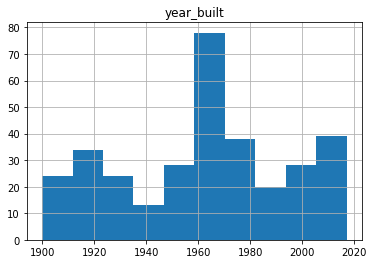

In [78]:
edu_building.hist(column='year_built')
print(f"Skewness of edu_building: ")
print(skew(edu_building['year_built'], nan_policy='omit'))

In [ ]:
print(f"edu_building data is almost perfectly symmetric (-0.15)")
print(f"resident_building ")

# TODO

1. calculate the mean value of the year of construction for each category
2. insert the resulting value into the appropriate gaps
3. check updated subsets for nanos



4. drop buildings from the Service category